## Accuracy impute2 algorithm.

The experiment involves testing the accuracy of the IMPUTE2 algorithm.  
The experimental idea is, from a file of genotyped individuals, to remove (mask) 10% of the total SNPs.  
Of those specific SNPs we are aware of the genotypes. So, starting from the file with the masked SNPs, I use the imputation algorithm to impute additional SNPs from a reference panel.  
To check the efficiency of the algorithm I check whether it has imputed the hidden SNPs and thus their genotypes for individuals.

chr19_0_5000_phased.haps = genotyped file then transformed to vcf
chr19_0_5000_10_percent.haps = file containing masked SNPs (10%)
chr19_0_5000_phased_90_percent.haps = file from which you get the imputed vcf


file_vcf_imputed = 'new_out_from_0_5000_imputed.vcf' = chr19_0_5000_phased.haps
file_vcf_genotyped = 'new_out_from_0_5000_genotyped.vcf' = chr19_0_5000_phased_90_percent.haps

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import os
from matplotlib import pyplot as plt
from scipy.stats import pearsonr

In [2]:
os.chdir('/Users/marcoreverenna/Desktop/IGENOMIX/2.ACCURACY_IMPUTE2/outputs/')
os.getcwd()

# variables of datasets
file_vcf_imputed = 'new_out_from_0_5000_imputed.vcf'
file_vcf_genotyped = 'new_out_from_0_5000_genotyped.vcf'
file_SNP_masked = 'masked_positions_10_percent.txt'

# creating my dataset
df_imputed = pd.read_csv(file_vcf_imputed, header=6, sep='\t')
df_geno = pd.read_csv(file_vcf_genotyped, header=5, sep='\t')
df_SNP_masked = pd.read_csv(file_SNP_masked, header=None, sep=' ')

#### List of masked mutations
This list contains SNPs already present in the genotyped dataset.  
The imputed dataset was obtained from the genotyped minus the 63 SNPs in the masked list.

In [3]:
df_SNP_masked.head()

,0,1,2,3
0,rs4375794,691909,T,C
1,rs2288953,538994,T,C
2,rs867169,2833864,A,G
3,rs4806933,3414020,T,C
4,rs7247434,3328734,G,A


In [4]:
list_SNP_mask = df_SNP_masked[1].to_list()
print(list_SNP_mask)

[691909, 538994, 2833864, 3414020, 3328734, 280299, 501900, 2889166, 2244072, 1351916, 2921008, 1413574, 1773999, 750583, 4243792, 2550852, 2313800, 817708, 1476432, 1673793, 2415245, 4466107, 1808863, 2803227, 2619143, 730235, 4889524, 2475685, 2032148, 899978, 1076063, 2410105, 464612, 1114119, 629303, 1005230, 3660619, 3159769, 4268341, 4538599, 4768917, 4735663, 2484806, 962161, 3215237, 3099982, 1642507, 2078488, 4534014, 1839483, 2833802, 2542673, 4859937, 2160529, 3520562, 4717672, 1372441, 411849, 1057789, 4995926, 3207646, 3281149, 331028]


#### Imputed dataset
I check the unique positions present in the imputed dataset.  
There are several repeated positions, so we need to understand why some of them are present more than once.

In [5]:
df_imputed.head(3)

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ctr-P199_ctr-P199,...,OB_748_OB_748,OB_776_OB_776,OB_553_OB_553,OB_620_OB_620,OB_641_OB_641,OB_666_OB_666,OB_694_OB_694,OB_718_OB_718,OB_758_OB_758,OB_777_OB_777
0,19,60842,19:60842:A:G,A,.,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
1,19,62935,19:62935:CCT:C,CCT,.,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0
2,19,64705,19:64705:C:T,C,.,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0


In [7]:
print(df_imputed.shape[0])
print(df_imputed['POS'].nunique())

185152

#### Genotyped dataset
The genotyped dataset appears to be cleaner; indeed, it appears that there are no repeats.  
However, it is possible that some variants are still repeated and some are completely discarded.

In [8]:
df_geno.head(3)

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ctr-P199,...,OB_748,OB_776,OB_553,OB_620,OB_641,OB_666,OB_694,OB_718,OB_758,OB_777
0,19,266034,rs2312724,C,T,.,PASS,.,GT,1|1,...,1|1,0|1,1|1,1|1,1|1,1|1,1|1,1|1,0|0,1|1
1,19,267039,rs1020382,C,T,.,PASS,.,GT,1|1,...,1|1,1|1,0|1,0|0,1|1,0|1,0|1,0|1,1|1,0|1
2,19,280299,rs11878315,C,T,.,PASS,.,GT,1|1,...,1|1,1|1,0|1,0|0,1|1,0|1,0|1,1|1,1|1,1|1


In [10]:
print(df_geno.shape[0])
print(df_geno['POS'].nunique())

638

#### Manipulation of the imputed dataset.

The imputation algorithm imputes not only SNPs but also INDELs, in some cases the SNP ALTERNATE is not even specified, so I decide to consider only point mutations, as in the genotyped dataset.

I create two new columns with reference to REF SNPs and ALT SNPs. 
In case the reference or alternate SNP is present a presence value of 1 will be assigned, otherwise the code automatically prints NaN.  
Next, the dataframe is reduced to SNPs only, so only columns with both REF_SNP = 1 and ALT_SNP = 1 will be referenced.

In [11]:
df_imputed.loc[(df_imputed.REF == 'A') | (df_imputed.REF == 'T') | (df_imputed.REF == 'C') | (df_imputed.REF == 'G'), 'REF_SNP'] = 1
df_imputed.loc[(df_imputed.ALT == 'A') | (df_imputed.ALT == 'T') | (df_imputed.ALT == 'C') | (df_imputed.ALT == 'G'), 'ALT_SNP'] = 1
df_imputed = df_imputed[(df_imputed['REF_SNP'] == 1.0) & (df_imputed['ALT_SNP'] == 1.0)]
df_imputed.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ctr-P199_ctr-P199,...,OB_553_OB_553,OB_620_OB_620,OB_641_OB_641,OB_666_OB_666,OB_694_OB_694,OB_718_OB_718,OB_758_OB_758,OB_777_OB_777,REF_SNP,ALT_SNP
3,19,69984,rs372156287:69984:G:A,G,A,.,.,PR,GT,./.,...,0/0,0/0,0/0,./.,0/0,0/0,0/0,0/0,1.0,1.0
14,19,89422,19:89422:T:C,T,C,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1.0,1.0
26,19,90553,19:90553:G:A,G,A,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1.0,1.0
33,19,91106,rs56343121:91106:A:C,C,A,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1.0,1.0
47,19,93193,19:93193:C:T,C,T,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1.0,1.0


Considering only the SNPs in the imputed dataset, I reduce the mutations by a factor of about 5 (from 185000 to 38000).

In [12]:
print(df_imputed.shape)

(38279, 970)

Gene dosages are established in two ways. Some REFs are already found before ALTs in chronological order, so I define a condition in which: if REF before ALT I apply a certain dictionary, or if REF is after ALT I apply a second dictionary. I create two dictionaries for the imputed dataset, dictionary 1 and 2. I use the former in the case where the REF comes before the ALT, and the latter in the case where the ALT comes before the REF.

In [13]:
imputed_dict_1 = {'0/0':0,'1/0':1,'0/1':1,'1/1':2,'./.':0}
imputed_dict_2 = {'0/0':2,'1/0':1,'0/1':1,'1/1':0,'./.':0}
# better to remove SNPs where missing are present? because by assigning 0 I favor homozygotes.
# more or less balanced considering that 0 of the ./. is first applied to recessive HMOs and then to dominant HMOs. 
# I could put numpy.nan but it gives problems later.

In [14]:
df_imputed_copy = df_imputed.copy()
df_geno_copy = df_geno.copy()

I replace the genotypes of df_imputed with the appropriate dictionaries.
I take the df_imputed dataframe and select only those rows where the REF is less than the ALT. The result is a vector with True or False.

In [16]:
df_imputed['REF'] < df_imputed['ALT']

3         False
14        False
26        False
33        False
47         True
          ...  
186498    False
186501     True
186515    False
186516    False
186530     True
Length: 38279, dtype: bool

At this point I implement a flipping logic that is the same as Shapeit would have done.

In [17]:
df_imputed_copy.loc[df_imputed_copy['REF'] < df_imputed_copy['ALT'],df_imputed_copy.columns[9:968]] = df_imputed.loc[df_imputed['REF'] < df_imputed['ALT']].iloc[:,9:968].replace(imputed_dict_1)
df_imputed_copy.loc[df_imputed_copy['REF'] > df_imputed_copy['ALT'],df_imputed_copy.columns[9:968]] = df_imputed.loc[df_imputed['REF'] > df_imputed['ALT']].iloc[:,9:968].replace(imputed_dict_2)

df_imputed_copy.head()
# be careful to use equal language logics.
# avoid using position indices (iloc) with column names (loc): pandas don't like mixtures.
# df_imputed_copy.columns[9:968] becomes a list of values

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ctr-P199_ctr-P199,...,OB_553_OB_553,OB_620_OB_620,OB_641_OB_641,OB_666_OB_666,OB_694_OB_694,OB_718_OB_718,OB_758_OB_758,OB_777_OB_777,REF_SNP,ALT_SNP
3,19,69984,rs372156287:69984:G:A,G,A,.,.,PR,GT,./.,...,0/0,0/0,0/0,./.,0/0,0/0,0/0,0/0,1.0,1.0
14,19,89422,19:89422:T:C,T,C,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1.0,1.0
26,19,90553,19:90553:G:A,G,A,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1.0,1.0
33,19,91106,rs56343121:91106:A:C,C,A,.,.,PR,GT,0/0,...,0/0,0/0,0/0,0/0,0/0,0/0,0/0,0/0,1.0,1.0
47,19,93193,19:93193:C:T,C,T,.,.,PR,GT,0,...,0,0,0,0,0,0,0,0,1.0,1.0


At this point, once the appropriate dictionaries are used, I can define a logic that the REF must be in alphabetical order before the ALT. In this way I can compare SNPs that have not been flipped.
The ID_DETAILED field contains an identifier that makes that SNP unique and consequently comparable with the genotyped dataset.

In [19]:
df_imputed_copy['NEW_REF'] = np.select([df_imputed.REF < df_imputed.ALT, df_imputed.ALT > df_imputed.REF], [df_imputed.REF, df_imputed.ALT], default=df_imputed.ALT)
df_imputed_copy['NEW_ALT'] = np.select([df_imputed.REF > df_imputed.ALT, df_imputed.ALT < df_imputed.REF], [df_imputed.REF, df_imputed.ALT], default=df_imputed.ALT)

df_imputed_copy['ID_DETAILED'] = df_imputed_copy['#CHROM'].astype(str) + ':' + df_imputed_copy['POS'].astype(str) + ':' + df_imputed_copy['NEW_REF'] + ':' + df_imputed_copy['NEW_ALT']

df_imputed_copy.head(5)

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,ctr-P199_ctr-P199,...,OB_641_OB_641,OB_666_OB_666,OB_694_OB_694,OB_718_OB_718,OB_758_OB_758,OB_777_OB_777,REF_SNP,ALT_SNP,NEW_REF,NEW_ALT
3,19,69984,rs372156287:69984:G:A,G,A,.,.,PR,GT,0,...,2,0,2,2,2,2,1.0,1.0,A,G
14,19,89422,19:89422:T:C,T,C,.,.,PR,GT,2,...,2,2,2,2,2,2,1.0,1.0,C,T
26,19,90553,19:90553:G:A,G,A,.,.,PR,GT,2,...,2,2,2,2,2,2,1.0,1.0,A,G
33,19,91106,rs56343121:91106:A:C,C,A,.,.,PR,GT,2,...,2,2,2,2,2,2,1.0,1.0,A,C
47,19,93193,19:93193:C:T,C,T,.,.,PR,GT,0,...,0,0,0,0,0,0,1.0,1.0,C,T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186498,19,4998997,19:4998997:G:A,G,A,.,.,PR,GT,2,...,2,2,2,2,2,2,1.0,1.0,A,G
186501,19,4999042,rs151122226:4999042:A:G,A,G,.,.,PR,GT,0,...,0,0,0,0,0,0,1.0,1.0,A,G
186515,19,4999367,rs185152320:4999367:G:A,G,A,.,.,PR,GT,2,...,2,2,2,2,2,2,1.0,1.0,A,G
186516,19,4999475,rs140634641:4999475:T:G,T,G,.,.,PR,GT,2,...,2,2,2,2,2,2,1.0,1.0,G,T


#### Genotyped dataset

In [21]:
geno_dict_1 = {'0|0':0,'1|0':1,'0|1':1,'1|1':2}
geno_dict_2 = {'0|0':2,'1|0':1,'0|1':1,'1|1':0}

df_geno_copy = df_geno.copy()

df_geno_copy.loc[df_geno_copy['REF'] < df_geno_copy['ALT'],df_geno_copy.columns[9:968]] = df_geno.loc[df_geno['REF'] < df_geno['ALT']].iloc[:,9:968].replace(geno_dict_1)
df_geno_copy.loc[df_geno_copy['REF'] > df_geno_copy['ALT'],df_geno_copy.columns[9:968]] = df_geno.loc[df_geno['REF'] > df_geno['ALT']].iloc[:,9:968].replace(geno_dict_2)

df_geno_copy['NEW_REF'] = np.select([df_geno_copy.REF < df_geno_copy.ALT, df_geno_copy.ALT > df_geno_copy.REF], [df_geno_copy.REF, df_geno_copy.ALT], default=df_geno_copy.ALT)
df_geno_copy['NEW_ALT'] = np.select([df_geno_copy.REF > df_geno_copy.ALT, df_geno_copy.ALT < df_geno_copy.REF], [df_geno_copy.REF, df_geno_copy.ALT], default=df_geno_copy.ALT)

df_geno_copy['ID_DETAILED'] = df_geno_copy['#CHROM'].astype(str) + ':' + df_geno_copy['POS'].astype(str) + ':' + df_geno_copy['NEW_REF'] + ':' + df_geno_copy['NEW_ALT']

df_geno_copy.head(10)

# list of IDs in common between geno and imputated.
list_intersect_ID = list(set(df_geno_copy.ID_DETAILED).intersection(df_imputed_copy.ID_DETAILED))
len(list_intersect_ID)


In [ ]:
df_r2 = pd.DataFrame()

for snp in list_intersect_ID:
    print (snp)
    
    v_geno = df_geno_copy[df_geno_copy.ID_DETAILED==snp].reset_index(drop=True).iloc[0,9:968]
    v_imp = df_imputed_copy[df_imputed_copy.ID_DETAILED==snp].reset_index(drop=True).iloc[0,9:968]
    
    pearson,pvalue = pearsonr(v_geno, v_imp)
    af = v_geno.mean()/2
    df_r2 = df_r2.append({'snp':snp,'af':af,'r2':pearson*pearson}, ignore_index=True)
    
print(len(v_geno),len(v_imp))

With this cycle I calculate the pearson coefficient for each SNP, for each SNP I calculate the allele frequency given by the mean value of the allelic assay / 2, then the values are put into a dataframe through a dictionary.
The "geno" and "imp" vectors contain the allelic assays for each individual, so they should contain 959 samples. Through the calculation of R2 I can understand how similar each pair of values of the two vectors are to each other, or rather, linearly aligned with each other. Pay attention to the ordering of the samples. Theoretically plink, in converting to vcf reports name.individual_family.individual. 
In the case where family is not present, it reports the individual's ID twice.

In [32]:
df_r2['POS'] = df_r2.snp.str.split(':').apply(lambda x: x[1]).astype(int)

df_r2.head()

,af,r2,snp,POS
0,0.538582,1.0,19:1920342:C:T,1920342
1,0.650156,1.0,19:2099820:A:G,2099820
2,0.665276,1.0,19:3256206:C:T,3256206
3,0.488008,1.0,19:3792364:A:G,3792364
4,0.396767,1.0,19:4488470:C:T,4488470


In [33]:
df_r2['MASKED'] = df_r2['POS'].isin(list_SNP_mask)

df_r2.MASKED.value_counts()

False    567
True      62
Name: MASKED, dtype: int64

### Grafici 

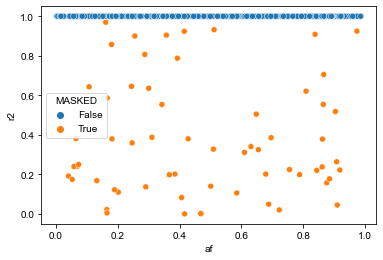

In [34]:
sns.scatterplot(data= df_r2, x = 'af', y = 'r2', hue = 'MASKED')
sns.set(rc = {'figure.figsize':(14,14)})

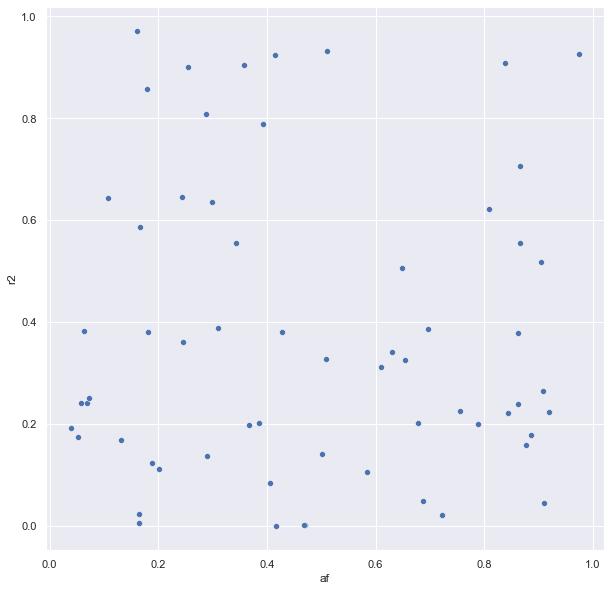

In [42]:
sns.scatterplot(data= df_r2[df_r2.MASKED==True], x = 'af', y= 'r2')
sns.set(rc = {'figure.figsize':(9,9)})

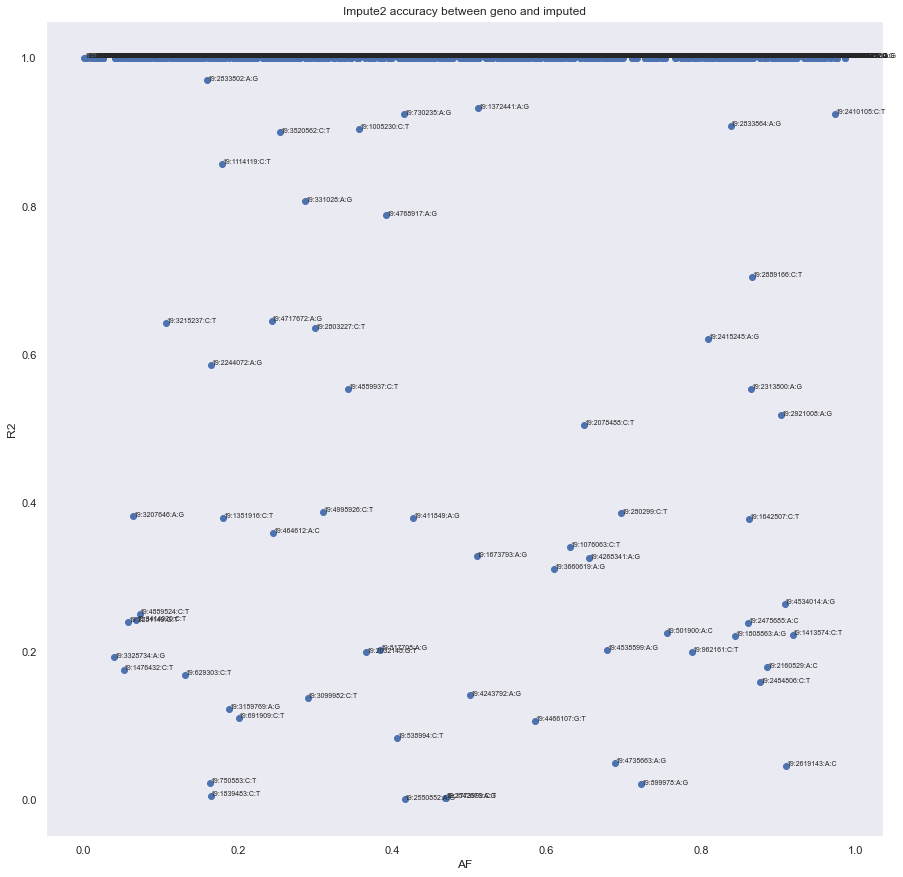

In [36]:
plt.figure(figsize = (15,15))

plt.scatter(df_r2.af, df_r2.r2)
plt.grid()

plt.title('Impute2 accuracy between geno and imputed')
plt.xlabel('AF')
plt.ylabel('R2')

for i,snp in df_r2.iterrows():
    plt.text(snp.af,snp.r2,snp.snp, size = 7)
    

Of these 629 SNPs, about 30 are snapped in the middle of the graph, and all the others stand at R2 = 1, would mean perfect correlation.
We here are comparing all SNPs in common between df_genotized and the imputed one. In these SNPs there are both masked ones (not known to the imputation algorithm) and unmasked ones. We need to see if the known ones return with an accuracy of 1 (should be so) and the unknown ones can have R2 between 0 and 1 depending on how effective the algorithm is. So one has to classify SNPs as known and unknown (masked and unmasked).

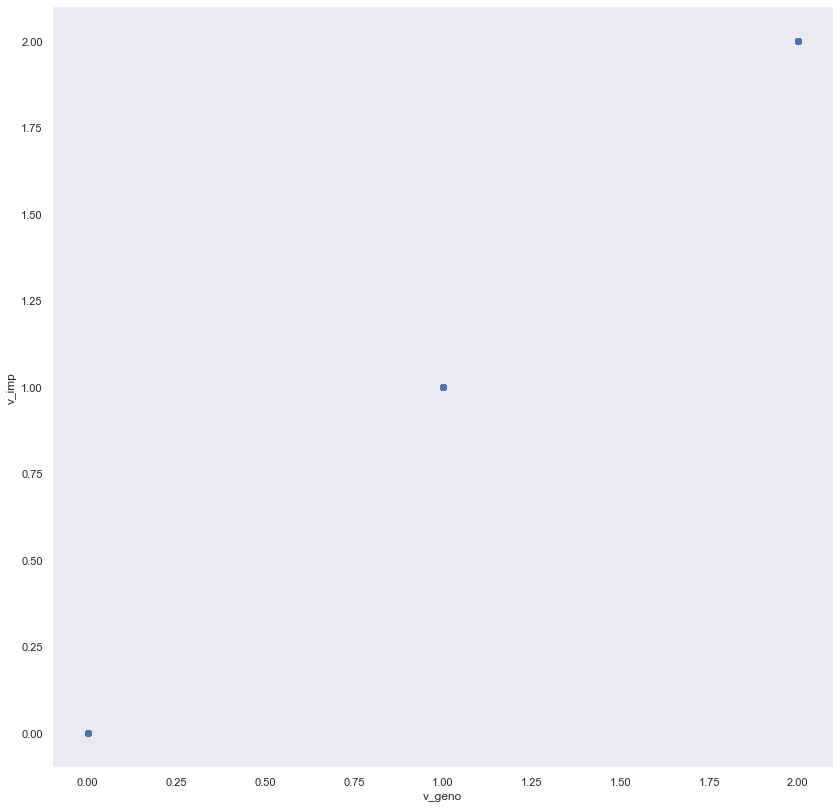

In [37]:
plt.scatter(v_geno,v_imp,alpha=0.1)
plt.xlabel('v_geno')
plt.ylabel('v_imp')
plt.grid()

Imputation is more accurate when we have common SNPs, while it is less accurate when we have rare SNPs. So we would need the allele frequency of the SNPs present in the REFERENCE, however we know the allele frequency of our sample (about 700 individuals) so it can be approximated to the REFERENCE.

In [39]:
df_r2_copy = df_r2.copy()

df_r2_1 = df_r2_copy.loc[df_r2['r2']== 1]
print(df_r2_1)

           af   r2             snp      POS  MASKED
0    0.538582  1.0  19:1920342:C:T  1920342   False
1    0.650156  1.0  19:2099820:A:G  2099820   False
6    0.785193  1.0  19:3009220:G:T  3009220   False
10   0.501043  1.0  19:2184005:C:T  2184005   False
12   0.861314  1.0  19:3024624:A:G  3024624   False
..        ...  ...             ...      ...     ...
623  0.317518  1.0  19:2576272:C:T  2576272   False
625  0.921794  1.0  19:3804701:C:T  3804701   False
626  0.126173  1.0  19:4837501:C:T  4837501   False
627  0.193952  1.0  19:1357082:C:T  1357082   False
628  0.570386  1.0  19:4493708:A:G  4493708   False

[359 rows x 5 columns]
